# Lista 6
### Zuzanna Sosnowska

In [135]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import pandas as pd
from IPython.display import display, HTML

In [136]:
# Kody z listy 2 do mnożenia, odwracania macierzy
from typing import Iterable
import copy

class Vector(Iterable):
    def __init__(self, elems=None):
        if elems is None:
            elems = []
        self.__elems = elems

    def __getitem__(self, key):
        return self.__elems[key]

    def __setitem__(self, key, val):
        self.__elems[key] = val

    def __len__(self):
        return len(self.__elems)

    def __iter__(self):
        return self.__elems.__iter__()

    def __add__(self, other):
        if len(self) != len(other):
            raise ValueError("Vector must be of equal length")
        return Vector([a + b for a, b in zip(self, other)])

    def __neg__(self):
        return Vector([-a for a in self.__elems])

    def __sub__(self, other):
        if len(self) != len(other):
            raise ValueError("Vector must be of equal length")
        return Vector([a - b for a, b in zip(self, other)])

    def __mul__(self, other):
        if len(self) != len(other):
            raise ValueError("Vector must be of equal length")
        return Vector([a * b for a, b in zip(self, other)])

    def __rmul__(self, other):
        return Vector([other * a for a in self.__elems])

    def __str__(self):
        comma_list = ''.join([str(a) + ', ' for a in self.__elems])
        return '<' + comma_list[:-2] + '>'

    def copy(self):
        return Vector([*self.__elems])

    def append(self, val):
        self.__elems.append(val)

    def norm(self):
        return sum(map(lambda x: abs(x), self.__elems))

    def norm_inf(self):
        return max(map(lambda x: abs(x), self.__elems))

class Matrix:

    def __init__(self):
        self.__rows = []

    @staticmethod
    def from_vectors(vectors):
        m = Matrix()
        for vec in vectors:
            m.add_row(vec)
        return m

    @staticmethod
    def create_from_list(list_of_lists):
        m = Matrix()
        for row in list_of_lists:
            m.add_row(Vector(row))
        return m

    @staticmethod
    def identity_matrix(n):
        I = [[1 if i == j  else 0 for i in range(n)] for j in range(n)]
        return Matrix.create_from_list(I)

    def number_of_rows(self):
        return len(self.__rows)

    def number_of_columns(self):
        return 0 if len(self.__rows) == 0 else len(self.__rows[0])

    def is_empty(self):
        return len(self.__rows) == 0

    def __len__(self):
        return self.number_of_rows() * self.number_of_columns()

    def __getitem__(self, item):
        return self.__rows[item]

    def __setitem__(self, key, new_row):
        self.__rows[key] = new_row

    def __str__(self):
        return ''.join([str(row) + '\n' for row in self.__rows])

    def __rmul__(self, other):
        return Matrix.create_from_list([other * row for row in self.__rows])

    def __sub__(self, other):
        if self.number_of_rows() != other.number_of_rows() and self.number_of_columns() != other.number_of_columns():
            raise ValueError("Matrix has different number of rows and columns")
        res = self.copy()
        for i in range(self.number_of_rows()):
            res[i] -= other[i]

        return res

    def __add__(self, other):
        if self.number_of_rows() != other.number_of_rows() and self.number_of_columns() != other.number_of_columns():
            raise ValueError("Matrix has different number of rows and columns")
        res = self.copy()
        for i in range(self.number_of_rows()):
            res[i] += other[i]

        return res

    def copy(self):
        return Matrix.from_vectors([row.copy() for row in self.__rows])

    def add_row(self, new_row):
        if len(new_row) != self.number_of_columns() and not self.is_empty():
            raise ValueError("Matrix rows must be of equal length")
        self.__rows.append(new_row)

    def add_column(self, new_column):
        if len(new_column) != self.number_of_rows():
            raise ValueError("Matrix columns must be of equal length")
        for i in range(self.number_of_rows()):
            self.__rows[i].append(new_column[i])

    def subtract_rows(self, row1, row2):
        self.__rows[row1] -= self.__rows[row2]

    def multiply_row(self, key, scalar):
        self.__rows[key] *= scalar

    def swap_rows(self, row1, row2):
        self.__rows[row1], self.__rows[row2] = self.__rows[row2], self.__rows[row1]

    def multiply_column(self, column, scalar):
        for row in self.__rows:
            row[column] *= scalar

    def subtract_column(self, index1, index2):
        for row in self.__rows:
            row[index1] -= row[index2]

    def upper_triangular_matrix(self):
        matrix = copy.deepcopy(self)
        if matrix.number_of_rows() == matrix.number_of_columns():
            for j in range(matrix.number_of_columns()):
                find_nullifying_row = False
                for i in range(j, matrix.number_of_rows()):
                    if matrix[i][j] != 0 and find_nullifying_row == False:
                        matrix.swap_rows(i, j)
                        find_nullifying_row = True
                        continue
                    if find_nullifying_row:
                        a = matrix[i][j] / matrix[j][j]
                        matrix[i] = matrix[i] - a * matrix[j]
                if not find_nullifying_row:
                    raise ValueError("Macierz osobliwa")
        return matrix

    def det(self):
        matrix = self.upper_triangular_matrix()
        det = 1
        for i in range(len(self.__rows)):
            det *= matrix[i][i]
        return det

    def multiply_matrix_by_vector(self, vector: Vector) -> Vector:
        if self.number_of_columns() != len(vector):
            raise ValueError("Vector length must be of equal to number of columns in matrix")
        new_vector = Vector()
        for row in self.__rows:
            new_vector.append(sum(row * vector))
        return new_vector

    def inv(self):
        if self.number_of_rows() != self.number_of_columns():
            raise ValueError("Matrix must be of equal length")
        matrix = copy.deepcopy(self)
        n = matrix.number_of_rows()
        I = Matrix.identity_matrix(n)
        for column in range(n):
            find_nullifying_row = False
            for row in range(column, n):
                if matrix[row][column] != 0 and find_nullifying_row == False:
                    matrix.swap_rows(row, column)
                    I.swap_rows(row, column)
                    find_nullifying_row = True
                    continue
                if find_nullifying_row:
                    modifier = matrix[row][column] / matrix[column][column]
                    matrix[row] = matrix[row] - modifier * matrix[column]
                    I[row] = I[row] - modifier * I[column]
            if not find_nullifying_row:
                raise ValueError("Macierz osobliwa")
        for column in range(n - 1, -1, -1):
            for row in range(column):
                modifier = matrix[row][column] / matrix[column][column]
                matrix[row] = matrix[row] - modifier * matrix[column]
                I[row] = I[row] - modifier * I[column]
            modifier = 1 / matrix[column][column]
            I[column] = modifier * I[column]
            matrix[column] = modifier * matrix[column]
        return I

    def norm(self):
        max = 0
        for row in self.__rows:
            if row.norm() > max:
                max = row.norm()
        return max

In [137]:
def polynomial_interpolation(points):
    """
    Funkcja oblicza interpolację wielomianową dla zadanych punktów.
    :param points: Punkty, w których będziemy obliczać interpolację wielomianową.
    :return: Funkcja zwraca wielomian (funkcję) o obliczonych na podstawie punktów współczynnikach .
    """
    n = len(points)
    # Tworzenie macierzy układu równań
    matrix_lst = []
    for i in range(n):
        row = np.zeros(n)
        for j in range(n):
            row[j] = points[i][0] ** j
        matrix_lst.append(row)

    A = Matrix.create_from_list(matrix_lst)
    b = Vector([points[i][1] for i in range(n)])
    A_inv = A.inv()
    # Współczynniki wielomianu interpolującego są rozwiązaniem układu równań liniowych
    coeffs = A_inv.multiply_matrix_by_vector(b)
    return coeffs


def polynomial(coef): return lambda x : sum(coef[i] * x ** i for i in range(len(coef)))


def integrate_trapezoidal(function, a, b, n):
    """
    Funkcja liczy przybliżoną wartość całki oznaczonej metodą trapezową
    :param function: Funkcja, której całkę chcemy policzyć
    :param a: Początkowy punkt przedziału całkowania
    :param b: Końcowy punkt przedziału całkowania
    :param n: Liczba przedziałów (podziałów) na których dokonujemy przybliżenia
    :return: Przybliżona wartość całki
    """
    n = n - 1 # Liczba podziałów przedziału mniejsza o 1
    
    # Obliczenie szerokości każdego przedziału
    h = (b - a) / n
    
    # Wartości funkcji w punkcie początkowym i końcowym
    x0 = function(a)
    xn = function(b)
    
    mid = 0
    for i in range(1, n):
        x = a + i * h  # Obliczamy x w odpowiednich punktach
        mid += function(x)    # Zmienna pomocnicza zapamiętująca wartość funkcji
    
    # Obliczamy wynik całkowania metodą trapezową
    integral = h * ((xn + x0) / 2 + mid)
    
    return integral


def integrate_simpson(function, a, b, n):
    """
    Funkcja liczy przybliżoną wartość całki oznaczonej metodą Simpsona.
    :param function: Funkcja, której całkę chcemy policzyć
    :param a: Początkowy punkt przedziału całkowania
    :param b: Końcowy punkt przedziału całkowania
    :param n: Liczba przedziałów
    :return: Przybliżona wartość całki
    """
    n = n - 1
    
    # Obliczenie szerokości każdego przedziału (h) z długości całkowitego przedziału
    h = (b - a) / n
    
    # Funkcja w punkcie początkowym i końcowym
    x0 = function(a)
    xn = function(b)
    
    # Zmienne pomocnicze
    xi = 0
    xj = 0
    
    for i in range(1, n):
        x = a + i * h  
        if i % 2 == 0:
            xi += function(x)
        else:
            xj += function(x)
    
    # Obliczamy wynik całkowania metodą Simpsona
    integral = h * (x0 + 4 * xj + 2 * xi + xn) / 3
    
    return integral


def GaussLegendre(function, a, b, weights, nodes):
    """
    Funkcja liczy przybliżoną wartość całki oznaczonej metodą Gaussa-Legendre'a
    :param function: Funkcja, której całki szukamy
    :param a: Początkowy punkt przedziału całkowania
    :param b: Końcowy punkt przedziału całkowania
    :param weights: Wagi dla węzłów w metodzie Gaussa-Legendre'a
    :param nodes: Węzły (miejsca) w metodzie Gaussa-Legendre'a
    :return: Przybliżona wartość całki
    """
    n = len(nodes)  # Liczba węzłów, która odpowiada rozmiarowi tablicy nodes (i weights)
    
    h = (b - a) / 2
    
    # Środek przedziału (c), wykorzystywany do transformacji
    c = (a + b) / 2
    
    val = 0
    for i in range(0, n):
        # Przekształcenie węzła (nodes) do odpowiednich punktów w oryginalnym przedziale
        val += weights[i] * function(h * nodes[i] + c)
    
    # Całkowita wartość całki, pomnożona przez połowę długości przedziału (h)
    integral = h * val
    
    return integral


### Zadanie 1

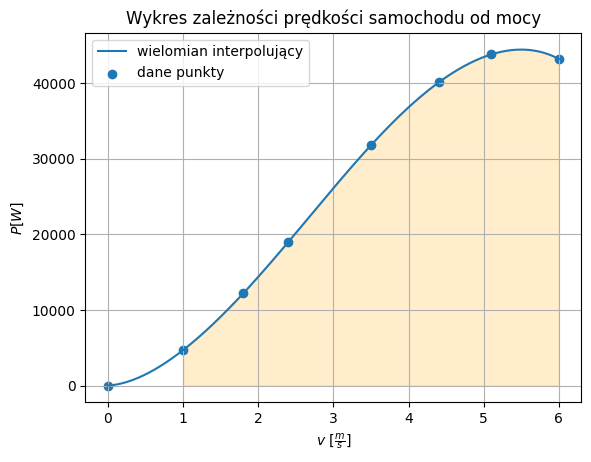

Czas potrzebny do rozpędzenia się samochodu (metoda trapezów): 1.27858 s
Czas potrzebny do rozpędzenia się samochodu (metoda simpsona): 1.27850 s
Czas potrzebny do rozpędzenia się samochodu (quad z pakietu scipy): 1.27850 s


In [138]:
v = np.array([0, 1.0, 1.8, 2.4, 3.5, 4.4, 5.1, 6.0])
P = np.array([0, 4.7, 12.2, 19.0, 31.8, 40.1, 43.8, 43.2]) * 1000    # Zamiana jednostki na jednostkę z układu SI - kW na W
points = list(zip(v, P))
m = 2000
v1 = 1
v2 = 6

# Interpolacja wielomianowa krzywej przechodzącej przez zadane punkty
phi_coeffs = polynomial_interpolation(points)
phi = polynomial(phi_coeffs)
v_curve = np.linspace(v[0], v[-1], 1000)

# Przedział całkowania
v_range = np.linspace(v1, v2, 1000)

plt.plot(v_curve, phi(v_curve), label='wielomian interpolujący')
plt.fill_between(v_range, phi(v_range), alpha=0.2, color='orange')
plt.scatter(v, P, label='dane punkty')
plt.title("Wykres zależności prędkości samochodu od mocy")
plt.xlabel(r"$v$ $[\frac{m}{s}]$")
plt.ylabel(r"$P [W]$")
plt.legend()
plt.grid(True)
plt.show()

def f(v): return v / phi(v)

# Obliczenie czasów
delta_t_trapezoidal = m * integrate_trapezoidal(function=f, a=v1, b=v2, n=101)
delta_t_simpson = m * integrate_simpson(function=f, a=v1, b=v2, n=101)
delta_t_scipy = m * integrate.quad(func=f, a=v1, b=v2)[0]

# Wyniki
print(f"Czas potrzebny do rozpędzenia się samochodu (metoda trapezów): {delta_t_trapezoidal:.5f} s")
print(f"Czas potrzebny do rozpędzenia się samochodu (metoda simpsona): {delta_t_simpson:.5f} s")
print(f"Czas potrzebny do rozpędzenia się samochodu (quad z pakietu scipy): {delta_t_scipy:.5f} s")

### Zadanie 2

In [139]:
# Funkcje do całkowania
def f(x): return np.cos(2 * np.power(np.cos(x), -1))

# Przedziały i węzły
a, b = -1, 1
nodes = np.array([3, 5, 7])

# Lista na wyniki
results = []


for n in nodes:
    result_simpson = integrate_simpson(function=f, a=a, b=b, n=n)
    result_scipy_simpson = integrate.simpson(y=f(np.linspace(a, b, n)), x=np.linspace(a, b, n))
    results.append({
        'n': n,
        'Funkcja': r'$\cos\left(2 \cdot \frac{1}{\cos(x)}\right)$',
        'Simpson (moje obliczenia)': result_simpson,
        'Simpson (scipy)': result_scipy_simpson
    })

# Tworzenie DataFrame z wynikami
df = pd.DataFrame(results)

# Wyświetlanie tabeli w Jupyter Notebooku
display(HTML(df.to_html(escape=False)))

,n,Funkcja,Simpson (moje obliczenia),Simpson (scipy)
0,3,$\cos\left(2 \cdot \frac{1}{\cos(x)}\right)$,-1.119685,-1.119685
1,5,$\cos\left(2 \cdot \frac{1}{\cos(x)}\right)$,-1.288409,-1.288409
2,7,$\cos\left(2 \cdot \frac{1}{\cos(x)}\right)$,-1.339188,-1.339188


### Zadanie 3

Zastosowanie podstawienia $x^3 = \frac{1}{t}$ prowadzi do następującego przekształcenia:

1. Wyrażenie $dx$ zostaje obliczone jako:
   $$
   dx = -\frac{1}{3t^{4/3}} \, dt
   $$

2. Przekształcamy przedziały całkowania:
   $$
   x \to \infty \implies t \to 0, \quad x \to 1 \implies t \to 1
   $$

3. Przekształcenie funkcji podcałkowej:
   $$
   \int_{1}^{\infty} \frac{1}{1 + x^4} \, dx = \int_{1}^{0} \frac{-1}{3t^{4/3}} \cdot \frac{1}{1 + \left( \frac{1}{t} \right)^4} \, dt
   $$

4. Uproszczenie prowadzi do:
   $$
   \int_{1}^{\infty} \frac{1}{1 + x^4} \, dx = \frac{1}{3} \int_{0}^{1}  \frac{1}{t^{4/3}} \cdot \frac{1}{1 + t^{-4/3}} \, dt = \frac{1}{3} \int_{0}^{1} \frac{1}{t^{4/3} + 1} \, dt
   $$


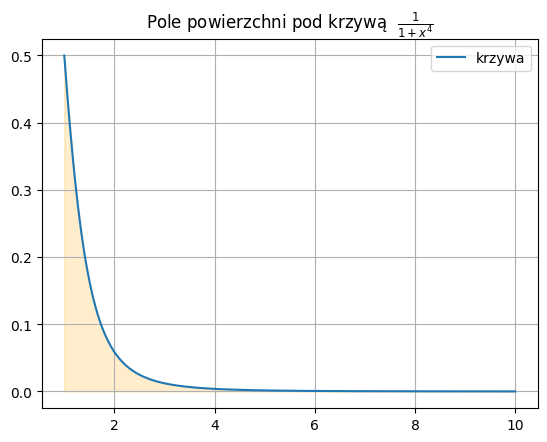

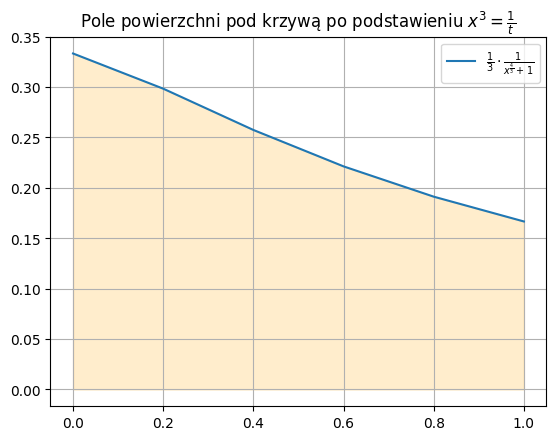

Wartość całki obliczona metodą trapezów:                       0.24369830404429738
Wartość całki obliczona metodą trapezów (z biblioteki scipy):  0.2436983040442973


In [140]:
n = 6

a, b = 1, np.inf
a2, b2 = 0, 1

def f1(x): return np.power(1 + np.power(x, 4), -1)

def f2(x): return 1 / 3 * np.power(np.power(x, 4 / 3) + 1, -1)

x = np.linspace(a, 10, 1000)
y = f1(x)

plt.plot(x, y, label="krzywa")
plt.fill_between(x, f1(x), alpha=0.2, color='orange')
plt.title(r"Pole powierzchni pod krzywą  $\frac{1}{1+x^4}$")
plt.grid(True)
plt.legend()
plt.show()

x = np.linspace(a2, b2, n)
y = f2(x)

plt.plot(x, y, label=r"$\frac{1}{3} \cdot \frac{1}{x^\frac{4}{3}+1}$")
plt.fill_between(x, f2(x), alpha=0.2, color='orange')
plt.grid(True)
plt.title(r"Pole powierzchni pod krzywą po podstawieniu $x^3 = \frac{1}{t}$")
plt.legend()
plt.show()

integ = integrate_trapezoidal(f2, a2, b2, n)
integ_scipy = integrate.trapezoid(y=y, x=x)

print("Wartość całki obliczona metodą trapezów:                      ", integ)
print("Wartość całki obliczona metodą trapezów (z biblioteki scipy): ", integ_scipy)

### Zadanie 4

In [141]:
def f(theta0, t): return np.power(1 - np.sin(theta0 / 2) ** 2 * np.sin(t) ** 2, -0.5)

def h1(theta0): return integrate_simpson(function=lambda t: f(theta0, t), a=a, b=b, n=1001)

def h2(theta0): return integrate_trapezoidal(function=lambda t: f(theta0, t), a=a, b=b, n=1001)

# Parametry
a, b = 0, np.pi / 2
theta0_degrees = np.array([15, 30, 45])  # Theta0 w stopniach
theta0_radians = theta0_degrees * np.pi / 360  # Theta0 w radianach

# Obliczenia
int_list = [h1(theta) for theta in theta0_radians]
int_list2 = [h2(theta) for theta in theta0_radians]

x = np.linspace(a, b, 1001)
scipy_int_list = [integrate.simpson(y=f(theta0, x), x=x) for theta0 in theta0_radians]
scipy_int_list2 = [integrate.trapezoid(y=f(theta0, x), x=x) for theta0 in theta0_radians]

# Tworzenie tabeli z wynikami
results = {
    r'$\theta_0$ (stopnie)': theta0_degrees,
    r'$\theta_0$ (radiany)': theta0_radians,
    r'$h(\theta_0)$ (Simpson)': int_list,
    r'$h(\theta_0)$ (Simpson scipy)': scipy_int_list,
    r'$h_2(\theta_0)$ (Trapez)': int_list2,
    r'$h_2(\theta_0)$ (Trapez scipy)': scipy_int_list2
}

df = pd.DataFrame(results)

display(HTML(df.to_html(escape=False)))

,$\theta_0$ (stopnie),$\theta_0$ (radiany),$h(\theta_0)$ (Simpson),$h(\theta_0)$ (Simpson scipy),$h_2(\theta_0)$ (Trapez),$h_2(\theta_0)$ (Trapez scipy)
0,15,0.130900,1.572480,1.572480,1.572480,1.572480
1,30,0.261799,1.577552,1.577552,1.577552,1.577552
2,45,0.392699,1.586071,1.586071,1.586071,1.586071


### Zadanie 5

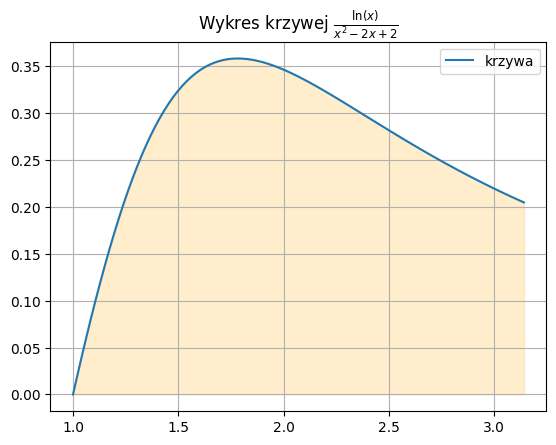

Wartość całki dla 2 węzłów:  0.6067250228624488
Wartość całki dla 4 węzłów:  0.5847680362127091


In [142]:
a, b = 1, np.pi

def f(x): return np.log(x) / (np.power(x, 2) - 2 * x + 2)

x = np.linspace(a, b, 100)
y = f(x)

plt.plot(x, y, label="krzywa")
plt.fill_between(x, y, alpha=0.2, color='orange')
plt.title(r"Wykres krzywej $\frac{\ln(x)}{x^2-2x+2}$")
plt.grid(True)
plt.legend()
plt.show()

nodes2, weights2 = np.polynomial.legendre.leggauss(2)
nodes4, weights4 = np.polynomial.legendre.leggauss(4)

int1 = GaussLegendre(f, a, b, weights=weights2, nodes=nodes2)
int2 = GaussLegendre(f, a, b, weights=weights4, nodes=nodes4)


print("Wartość całki dla 2 węzłów: ", int1)
print("Wartość całki dla 4 węzłów: ", int2)

In [143]:
# Przybliżenia pochodnych 

def forward_difference(f, x, h):
    return (f(x + h) - f(x)) / h

def backward_difference(f, x, h):
    return (f(x) - f(x - h)) / h

def central_difference(f, x, h):
    return (f(x + h) - f(x - h)) / (2 * h)

def extrapolated_difference(f, x, h):
    return (8 * f(x + h) - 8 * f(x - h) - f(x + 2 * h) + f(x - 2 * h)) / (12 * h)

### Zadanie 6

In [144]:
def f1(x):
    return x ** 3 - 2 * x

def f2(x):
    return np.sin(x)

def f3(x):
    return np.exp(x)


# Obliczenia dla podanych funkcji i punktów
points = [
    {"func": f1, "prime": 1, "x": 1},
    {"func": f2, "prime": 0.5, "x": np.pi / 3},
    {"func": f3, "prime": 1, "x": 0},
]

h_values = [0.1, 0.01, 0.001]

results = []

# Oblicz różnice dla każdej funkcji i punktu
for point in points:
    func, prime, x = point["func"], point["prime"], point["x"]
    for h in h_values:
        fd = forward_difference(func, x, h)
        cd = central_difference(func, x, h)
        ed = extrapolated_difference(func, x, h)
        results.append({
            "$x$": x,
            "$h$": h,
            "$f'(x) - D_{f1}$": abs(fd - prime),
            "$f'(x) - D_{c2}$": abs(cd - prime),
            "$f'(x) - D_{c4}$": abs(ed - prime),
        })

# Tworzenie DataFrame z wynikami
df = pd.DataFrame(results)

# Wyświetlanie tabeli w Jupyter Notebooku
df


,$x$,$h$,$f'(x) - D_{f1}$,$f'(x) - D_{c2}$,$f'(x) - D_{c4}$
0,1.000000,0.100,0.310000,1.000000e-02,1.110223e-15
1,1.000000,0.010,0.030100,1.000000e-04,4.662937e-15
2,1.000000,0.001,0.003001,1.000000e-06,3.619327e-14
3,1.047198,0.100,0.044098,8.329168e-04,1.664684e-06
4,1.047198,0.010,0.004338,8.333292e-06,1.666588e-10
5,1.047198,0.001,0.000433,8.333340e-08,1.105782e-13
6,0.000000,0.100,0.051709,1.667500e-03,3.337304e-06
7,0.000000,0.010,0.005017,1.666675e-05,3.333481e-10
8,0.000000,0.001,0.000500,1.666667e-07,2.686740e-14


### Zadanie 7

In [145]:
x = np.array(  [0.0,        0.1,       0.2,     0.3,    0.4])
f_x = np.array([0.000000, 0.078348, 0.138910, 0.192916, 0.244981])

x0 = 0.2

h = 0.1

def f(x0):
    # Szukanie indeksu w tablicy, dla którego element x[i] ma wartość x0 - x (z pewną dokładnością)
    i = np.where(abs(x0 - x) < 1.e-16)[0][0]
    return f_x[i]

f_prime = extrapolated_difference(f, x0, h)
print(f"Najlepsze przybliżenie pochodnej w punkcie x0 = {x0}: ", f_prime)

Najlepsze przybliżenie pochodnej w punkcie x0 = 0.2:  0.5596358333333332


### Zadanie 8

In [146]:
x = [-2.2, -0.3, 0.8, 1.9]
f_x = [15.180, 10.962, 1.920, -2.040]
points = list(zip(x, f_x))

coeffs = polynomial_interpolation(points)
poly = polynomial(coeffs)

x0 = 0
h_lst = np.array([0.1, 0.01, 0.001])

# Tworzenie tabeli wyników
columns = ['h', 'Dokładna wartość pochodnej', 'Różnice w przód', 
           'Różnice wstecz', 'Różnice centralne', 'Różnice ekstrapolowane']
results = []

# Iteracja po krokach h
for h in h_lst:
    real_value = coeffs[1]  # Dokładna pochodna z wielomianu interpolacyjnego
    der1 = forward_difference(poly, x0, h)       # Różnice w przód
    der2 = backward_difference(poly, x0, h)     # Różnice wstecz
    der3 = central_difference(poly, x0, h)      # Różnice centralne
    der4 = extrapolated_difference(poly, x0, h) # Różnice ekstrapolowane
    
    # Dodanie wyników jako wiersza
    results.append([h, real_value, der1, der2, der3, der4])

# Konwersja wyników na DataFrame
table = pd.DataFrame(results, columns=columns)

print(table)

def second_derivative(f, x, h):
    return (f(x + h) - 2 * f(x) + f(x - h)) / h**2


f_second_derivative = second_derivative(poly, x0, h)
print("Wartość drugiej pochodnej: ", f_second_derivative)
print("WRzeczywista wartość drugiej pochodnej: ", 2 * coeffs[2])
print("")

       h  Dokładna wartość pochodnej  Różnice w przód  Różnice wstecz  \
0  0.100                       -8.56        -8.580000       -8.520000   
1  0.010                       -8.56        -8.562900       -8.556900   
2  0.001                       -8.56        -8.560299       -8.559699   

   Różnice centralne  Różnice ekstrapolowane  
0          -8.550000                   -8.56  
1          -8.559900                   -8.56  
2          -8.559999                   -8.56  
Wartość drugiej pochodnej:  -0.5999999999062311
WRzeczywista wartość drugiej pochodnej:  -0.6000000000000012

